# 3D Convolutional Neural Network for Tomographic Alignment

## Regular CNN Expanding the Dataset

In order to test potential methods for performing automatic tomographic alignment using neural networks, we start with a standard model using a three dimensional convolution. The main problem with tomographic alignment is that a stack of two dimensional projections have to be processed simultameously for optimal results. While two dimensional convolutions can be used with channels corresponding with each projection angle, this is likely similar in computational complexity to a three dimensional neural network. Therefore the approach for this test is similar to video classification, where each frame in a video is is instead each projection angle. Now the dataset will be expanded to be larger in order to determine if this can be generalized on the phantom data.

In order to test if this method can provide a convergence, phantoms will be artificially misaligned to create a training and testing set. But first packages for tomography, image transformations, and neural networks have to be imported.

In [1]:
# Import essential packages
import os
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

Since the model will be a computationally complex CNN, we must ensure that the GPU is being used for calculations or else computation will be far too slow.

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True


Now that the packages have been imported and CUDA is set up correctly, the next step is to create the dataset to be used for training and testing the neural network. The misalignment function is created to perform different random misalignments on the phantom set of tomographic scans. The shape of all of the data is then checked for errors and the data is split into training and testing sets.

In [3]:
# Define function for artificial misalignment
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    dx = mis_axis[:, 0]
    dy = mis_axis[:, 1]
    prj_tmp = tomopy.shift_images(prj, dx, dy)
    
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
        
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
            
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()  
            
    return prj_tmp

In [4]:
# Creating ground truth tomography
data = tomopy.shepp3d(128)
ang = tomopy.angles(180)
proj = tomopy.project(data, ang)

In [5]:
# Create dataset to store misaligned projections and 
training_entries = 1000
entries = int(np.ceil(training_entries * 5 / 4))
dataset = np.zeros((entries, 2), dtype = object)

for i in range(entries):
    # Randomly determined misalignment axis
    mis_axis = np.random.normal(0, 1, (200, 3))
    mis_axis[:, :1] = mis_axis[:, :1]*4
    mis_axis = np.round(mis_axis).astype(int)
    mis_axis_in = np.expand_dims(mis_axis, axis = 0)
    
    proj_mis = misalign(proj.copy(), mis_axis, ang_tilt = True)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    
    dataset[i, 0] = proj_mis
    dataset[i, 1] = np.concatenate((mis_axis_in[:, :180, 0], mis_axis_in[:, :180, 1]), axis = 1)

In [6]:
# Checking shape of dataset
print(dataset.shape)
print(dataset[0].shape)
print(dataset[0][0].shape)
print(dataset[0][1].shape)

(1250, 2)
(2,)
(1, 1, 180, 128, 184)
(1, 360)


In [7]:
# Checking shape of training and testing splits
trainset, testset = np.split(dataset, [training_entries])
print(trainset.shape)
print(testset.shape)

(1000, 2)
(250, 2)


Now that the data has been set up, the CUDA cache should be cleared and the model will be implemented.

In [8]:
torch.cuda.empty_cache()
print("Cleared Cache.")

Cleared Cache.


In [9]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# 3D CNN to determine shift parameters

class CNN_3D_aligner(nn.Module):
    def __init__(self):
        super(CNN_3D_aligner, self).__init__()

        self.group1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        
        self.group3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(64),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(128),
            nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(128),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group5 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(256),
            nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(256),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group6 = nn.Sequential(
            nn.Conv3d(256, 16, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(16),
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(1600, 512),
            nn.Dropout(0.20),
            nn.Linear(512, 256)
        )
        
        self.fc2 = nn.Linear(256, 360)

    def forward(self, x):
        
        x = norm(x)
        
        x = self.group1(x)
        x = self.group2(x)
        x = self.group3(x)
        x = self.group4(x)
        x = self.group5(x)
        x = self.group6(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In order to ensure the network works and understand its structure before training data on it, use the summary function in order to get an understanding of the network and fix any linear algebra errors in creating the neural network.

In [10]:
# Test model shape
model = CNN_3D_aligner()
summary(model, (1, 1, 180, 128, 184))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_3D_aligner                           [1, 360]                  --
├─Sequential: 1-1                        [1, 16, 90, 64, 92]       --
│    └─Conv3d: 2-1                       [1, 16, 180, 128, 184]    448
│    └─BatchNorm3d: 2-2                  [1, 16, 180, 128, 184]    32
│    └─MaxPool3d: 2-3                    [1, 16, 90, 64, 92]       --
├─Sequential: 1-2                        [1, 32, 45, 32, 46]       --
│    └─Conv3d: 2-4                       [1, 32, 90, 64, 92]       13,856
│    └─BatchNorm3d: 2-5                  [1, 32, 90, 64, 92]       64
│    └─MaxPool3d: 2-6                    [1, 32, 45, 32, 46]       --
├─Sequential: 1-3                        [1, 64, 22, 16, 23]       --
│    └─Conv3d: 2-7                       [1, 64, 45, 32, 46]       55,360
│    └─BatchNorm3d: 2-8                  [1, 64, 45, 32, 46]       128
│    └─Conv3d: 2-9                       [1, 64, 45, 32, 46]       110,656


Now the model can be trained, making sure to move all of the elements of the training process to the GPU to optimize computational speed.

In [11]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = CNN_3D_aligner()
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 2e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 1000

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device)), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device)), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 8.642643230438232 
Epoch: 0   Validation Loss: 8.563699531555176 
Epoch: 1   Training Loss: 8.609818638324738 
Epoch: 1   Validation Loss: 8.655936079025269 
Epoch: 2   Training Loss: 8.601429895401001 
Epoch: 2   Validation Loss: 8.75670161819458 
Epoch: 3   Training Loss: 8.596141483783722 
Epoch: 3   Validation Loss: 8.724922523498535 
Epoch: 4   Training Loss: 8.596008585929871 
Epoch: 4   Validation Loss: 8.738231664657592 
Epoch: 5   Training Loss: 8.59750215768814 
Epoch: 5   Validation Loss: 8.696263256072998 
Epoch: 6   Training Loss: 8.597915828704833 
Epoch: 6   Validation Loss: 8.693554763793946 
Epoch: 7   Training Loss: 8.594435597896576 
Epoch: 7   Validation Loss: 8.742098991394043 
Epoch: 8   Training Loss: 8.596364966869354 
Epoch: 8   Validation Loss: 8.61024478340149 
Epoch: 9   Training Loss: 8.59762455558777 
Epoch: 9   Validation Loss: 8.57925965309143 
Epoch: 10   Training Loss: 8.601579393863679 
Epoch: 10   Validation L

Epoch: 88   Training Loss: 8.58947057723999 
Epoch: 88   Validation Loss: 8.83425366783142 
Epoch: 89   Training Loss: 8.593850605487823 
Epoch: 89   Validation Loss: 8.69634292793274 
Epoch: 90   Training Loss: 8.593288571357727 
Epoch: 90   Validation Loss: 8.62561773300171 
Epoch: 91   Training Loss: 8.59214875793457 
Epoch: 91   Validation Loss: 8.646277307510376 
Epoch: 92   Training Loss: 8.593090329170227 
Epoch: 92   Validation Loss: 8.651688636779785 
Epoch: 93   Training Loss: 8.591628393173218 
Epoch: 93   Validation Loss: 8.655544601440429 
Epoch: 94   Training Loss: 8.59320011138916 
Epoch: 94   Validation Loss: 8.716644279479981 
Epoch: 95   Training Loss: 8.589705968856812 
Epoch: 95   Validation Loss: 8.696051061630248 
Epoch: 96   Training Loss: 8.591252727031709 
Epoch: 96   Validation Loss: 8.655776252746582 
Epoch: 97   Training Loss: 8.592098700523376 
Epoch: 97   Validation Loss: 8.718390188217164 
Epoch: 98   Training Loss: 8.589513939857483 
Epoch: 98   Validati

Epoch: 174   Training Loss: 8.58823017168045 
Epoch: 174   Validation Loss: 8.747939893722535 
Epoch: 175   Training Loss: 8.590489282131195 
Epoch: 175   Validation Loss: 8.75098991394043 
Epoch: 176   Training Loss: 8.590502599716187 
Epoch: 176   Validation Loss: 8.66930061531067 
Epoch: 177   Training Loss: 8.588084573745727 
Epoch: 177   Validation Loss: 8.653852022171021 
Epoch: 178   Training Loss: 8.586275534629822 
Epoch: 178   Validation Loss: 8.669071996688842 
Epoch: 179   Training Loss: 8.58651868057251 
Epoch: 179   Validation Loss: 8.719119916915893 
Epoch: 180   Training Loss: 8.584412204742431 
Epoch: 180   Validation Loss: 8.672446311950683 
Epoch: 181   Training Loss: 8.581327202320098 
Epoch: 181   Validation Loss: 8.651077392578125 
Epoch: 182   Training Loss: 8.586694644927979 
Epoch: 182   Validation Loss: 8.661489274978639 
Epoch: 183   Training Loss: 8.58706369638443 
Epoch: 183   Validation Loss: 8.737984273910522 
Epoch: 184   Training Loss: 8.587377392292023

Epoch: 260   Training Loss: 8.580712954998017 
Epoch: 260   Validation Loss: 8.703208503723145 
Epoch: 261   Training Loss: 8.585499019145965 
Epoch: 261   Validation Loss: 8.701355556488037 
Epoch: 262   Training Loss: 8.585973012447358 
Epoch: 262   Validation Loss: 8.628688653945924 
Epoch: 263   Training Loss: 8.58925435590744 
Epoch: 263   Validation Loss: 8.619425382614136 
Epoch: 264   Training Loss: 8.589356283187866 
Epoch: 264   Validation Loss: 8.655866556167602 
Epoch: 265   Training Loss: 8.590764015197754 
Epoch: 265   Validation Loss: 8.572189121246337 
Epoch: 266   Training Loss: 8.586740717887878 
Epoch: 266   Validation Loss: 8.637754669189453 
Epoch: 267   Training Loss: 8.588712004184723 
Epoch: 267   Validation Loss: 8.674295984268188 
Epoch: 268   Training Loss: 8.590760768413544 
Epoch: 268   Validation Loss: 8.64420712852478 
Epoch: 269   Training Loss: 8.587794331550597 
Epoch: 269   Validation Loss: 8.743238996505736 
Epoch: 270   Training Loss: 8.589768385887

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Now in order to observe convergence or lack thereof a graph of loss per epoch are created for analysis.

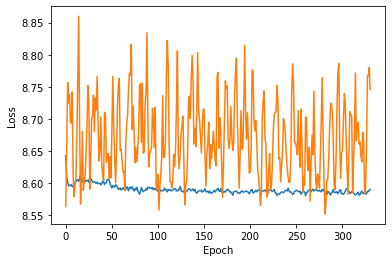

In [12]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Through this step of the process, it shows that convergence is possible for training data when the amount of entries is small. However, this comes with the caveat of the testing data not converging and multiple techniques to solve overfitting were found to not be satisfactory. Then the size of the training data was increased but this resulted in loss of convergence altogether, suggesting that the existing neural net is not sufficient to solve this problem. Now that a more traditional structure has been ruled out of the questions, the next logical step is to use another network design used for image alignment with larger data size: ResNet.